In [1]:
#used bz 4fgl and 4lac
#first step - bz and 4fgl combine , 
#got a good overlap - meaning - 1506 mentioned and obtained the same 
#then combined with 4lac we get 1434 around, dont know how much to get 
#plotted neutrino flux and neutrino energy peak values 


import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 
from astropy.coordinates import SkyCoord
from astropy import units as u
from time import time
from astropy.table import Table
from astropy.io import fits


#def frame_conversion(red_shift,syn_peak):
#    log_syn_peak_emitted = np.log10(syn_peak)+np.log10(1+z)
#    return( log_syn_peak_emitted )

def angular_dist(r1, d1, r2, d2):
    a = np.sin(np.abs(d1 - d2)/2)**2
    b = np.cos(d1)*np.cos(d2)*np.sin(np.abs(r1 - r2)/2)**2
    return 2*np.arcsin(np.sqrt(a + b))

def crossmatch_tree(coords1, coords2, max_of_radius):
    #start_time = time()
    max_radius = max_of_radius
    matches = []
    no_matches = []
    
    # Convert to astropy coordinates objects
    coords1_sc = SkyCoord(coords1*u.degree, frame='icrs')
    coords2_sc = SkyCoord(coords2*u.degree, frame='icrs')
    
    # Perform crossmatching
    closest_ids, closest_dists, _ = coords1_sc.match_to_catalog_sky(coords2_sc)
    
    for id1, (closest_id2, dist) in enumerate(zip(closest_ids, closest_dists)):
        closest_dist = dist.value
        # Ignore match if it's outside the maximum radius
        if closest_dist > max_radius:
            no_matches.append(id1)
        else:
            matches.append([id1, closest_id2, closest_dist])
    return(matches,no_matches)


#Defining 3 different functions for the 3 different regions  

#Bl_Lac region 
def BL_Lac(vs_peak,z,delta):
    a = (17.5)/(1+z)**2 
    b = (delta/10)**2
    c = (vs_peak)/(10**16)
    return(1000*(a*b)/c)
    #return(vs_peak+z+delta)
#BL_Lac(1.0,1.0,1.0)


#Fsrq_ blazarzone
def FSRQ_Blazarzone(E_s,Gamma):
    a = 80*Gamma**2
    b = (E_s/10)
    return(1000*a/b)

#converting sync prak from our frame to emitted frame 
def frame_conversion(red_shift,syn_peak):
    log_syn_peak_emitted = np.log10(syn_peak)+np.log10(1+z)
    return( log_syn_peak_emitted )

def frame_conversion_normal(red_shift,answer):
    z=red_shift
    return(answer/(1+z)**2)

#fsrq_BLR region 
def FSRQ_BLR(E_BL , delta_epsilon):
    a = 0.05*(0.5*(928.2))*delta_epsilon
    return(a/E_BL)


In [2]:
#matching BZ and 4fgl

#reading both the catalogues 
BZ = pd.read_csv("romabzcat_full.csv")

#some necessary manu=ipulation to 4fgl table to get final flux from 1 to 300gev 
fgl4_less= pd.read_csv("4fgl.csv")
fgl4_more = pd.read_csv("4fgl_.csv")
fgl4 = pd.merge(fgl4_less,fgl4_more,on="id ")
fgl4_cri= pd.read_csv("4fgl_alotmore.csv")
fgl4 = pd.merge(fgl4,fgl4_cri[['id ',' NuFNu 50-100 MeV (erg /cm2/s) ', ' NuFNu 100-300 MeV (erg /cm2/s) ',' NuFNu 300-1000 MeV (erg /cm2/s) ']],on="id ")

fgl4['total neutrino flux'] = 0.33*0.1*(fgl4[' NuFNu 1-3 GeV (erg /cm2/s) '] + fgl4[' NuFNu 3-10 GeV (erg /cm2/s) ']+
       fgl4[' NuFNu 10-30 GeV (erg /cm2/s) '] + fgl4[' NuFNu 30-300 GeV (erg /cm2/s)']+ fgl4[' NuFNu 50-100 MeV (erg /cm2/s) ']+ fgl4[' NuFNu 100-300 MeV (erg /cm2/s) ']+ fgl4[' NuFNu 300-1000 MeV (erg /cm2/s) '])


#hsp3 = pd.read_csv("3hsp.csv")
fgl4 = fgl4.replace(r'^\s*$', np.NaN, regex=True)
#hsp3 = hsp3.replace(r'^\s*$', np.NaN, regex=True)
BZ = BZ.replace(r'^\s*$', np.NaN, regex=True)

#hsp3 = hsp3[hsp3.columns[[1,2,3,4,10]]]
#fgl4 = fgl4[fgl4.columns[[1,2,3,4,8,12,-3,-2,14]]]
#BZ=BZ[BZ.columns[[1,2,3,4,5,6,9]]]

cat0 = np.array(BZ[[' RA (J2000.0) ', ' Dec (J2000.0) ']])
#cat1 = np.array(hsp3[hsp3.columns[[2,3]]])
cat2 = np.array(fgl4[[' R.A. Counterpart ', ' Dec. Counterpart ']])

radius_input = 0.000345
bfmatched=[]
bfunmatched=[]
bfmatched,bfunmatched= crossmatch_tree(cat0,cat2,radius_input)

matched1=np.array(bfmatched)
matched_id1 = matched1[:,0]
matched_id1 = matched_id1.astype(int)
matched_id2 = matched1[:,1]
matched_id2 = matched_id2.astype(int)

#hsp3=hsp3.iloc[matched_id1]
BZ=BZ.iloc[matched_id1]
fgl4=fgl4.iloc[matched_id2]

BZ = BZ.reset_index()
fgl4 = fgl4.reset_index()
final_bf = pd.merge(BZ, fgl4, left_index=True, right_index=True)
len(bfmatched)

1506

In [3]:
fname='table_4LAC.fits'
hdul = fits.open(fname)
#data = np.array(shape=(2863,38), buffer=big_end_buffer)
data = hdul[1].data
hdr = hdul[1].header
#dat_from_fits(hdr)
#hdul.close()
hdul.info()
#hdul[1].data.dtype
print(hdr)
data.dtype
lac4 = pd.DataFrame(np.array(data).byteswap().newbyteorder())
str_df = lac4.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()
for col in str_df:
    lac4[col] = str_df[col]
    
#reading both the catalogues 
#BZ = pd.read_csv("romabzcat_full.csv")
#fgl4= pd.read_csv("4fgl.csv")
#fgl4 = fgl4.replace(r'^\s*$', np.NaN, regex=True)
#BZ = BZ.replace(r'^\s*$', np.NaN, regex=True)

cat0 = np.array(final_bf[[' RA (J2000.0) _y',' Dec (J2000.0) _y']])
#cat1 = np.array(hsp3[hsp3.columns[[2,3]]])
#cat2 = np.array(fgl4[fgl4.columns[[-3,-2]]])
cat2 = np.array(lac4[['RAJ2000', 'DEJ2000']])

radius_input = 0.000013
bfmatched=[]
bfunmatched=[]
bfmatched,bfunmatched= crossmatch_tree(cat2,cat0,radius_input)

matched1=np.array(bfmatched)
matched_id1 = matched1[:,0]
matched_id1 = matched_id1.astype(int)
matched_id2 = matched1[:,1]
matched_id2 = matched_id2.astype(int)

#hsp3=hsp3.iloc[matched_id1]
final_bf=final_bf.iloc[matched_id2]
lac4=lac4.iloc[matched_id1]

final_bf = final_bf.reset_index()
lac4 = lac4.reset_index()
bz_4lac = pd.merge(final_bf, lac4, left_index=True, right_index=True)
len(bfmatched)
#only 841 remain with bzcat classification 
#779 match for 20 arc degrees - 0.349 radians
#788 match for 1 radians

Filename: table_4LAC.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  4LAC AGNs     1 BinTableHDU    170   2863R x 38C   ['18A', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', '18A', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'I', '6A', '30A', 'E', 'E', '20A', 'D', 'D', 'E', '20A', '30A', 'E', 'E', '6A', 'E', 'E', 'E', 'E', 'E', 'E']   
XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  274 / length of dimension 1                          NAXIS2  =                 2863 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS =                   38 / numb

1407

In [4]:
bz_4lac = bz_4lac.loc[bz_4lac['nu_syn'].notnull()]

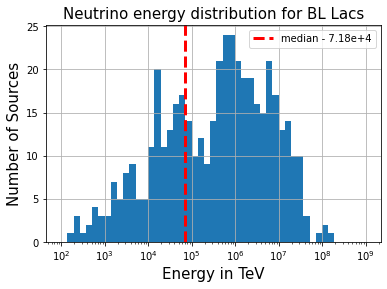

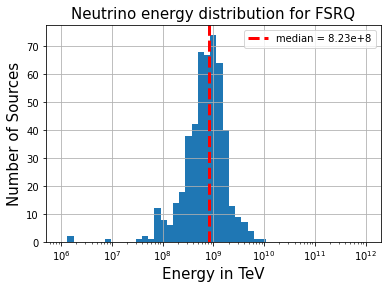

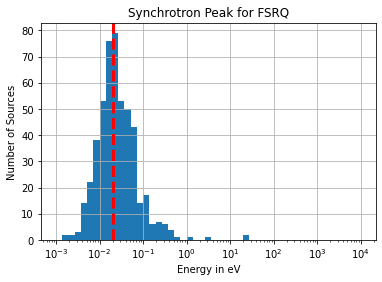

In [5]:
bz_4lac['nu_syn_peak'] = pd.to_numeric(bz_4lac['nu_syn'],errors='coerce')

#making alterations to get data in processable way 

bz_4lac['Redshift'] = pd.to_numeric(bz_4lac['Redshift'],errors='coerce')
#BZ[' Source classification']=BZ[' Source classification'].astype('str')
#BZ[' BZcat name ']=BZ[' BZCAT5 Source name ']

#energy in eV from Hz
bz_4lac['nu_syn_peak_in_eV']=bz_4lac['nu_syn_peak']*(4.135*(10**(-15)))


#finally running the code to get values for the 3 functions corresponding to each entry (bad english )7

bz_4lac['if_BLLac'] = BL_Lac(bz_4lac['nu_syn_peak'],bz_4lac['Redshift'], 15.0 )

bz_4lac['if_FSRQ_BR']= FSRQ_Blazarzone(bz_4lac['nu_syn_peak_in_eV'],10.0)

bz_4lac['answer']=frame_conversion_normal(bz_4lac['Redshift'],bz_4lac['if_FSRQ_BR'])



category_bll=bz_4lac.loc[bz_4lac['CLASS']=='bll']
plt.hist(category_bll['if_BLLac'], bins=np.logspace(np.log10(100.0),np.log10(1000000000.0), 50))
plt.axvline(category_bll['if_BLLac'].median(), color='r', linestyle='dashed', linewidth=3,label='median - 7.18e+4')
plt.gca().set_xscale("log")
plt.xlabel('Energy in TeV',fontsize='15',)
plt.ylabel('Number of Sources',fontsize='15')
plt.grid()
plt.legend()
plt.title('Neutrino energy distribution for BL Lacs',fontsize='15')
plt.show()

category_fsrq=bz_4lac.loc[bz_4lac['CLASS']=='fsrq']
plt.hist(category_fsrq['answer'], bins=np.logspace(np.log10(1000000.0),np.log10(1000000000000.0), 50))
plt.axvline(category_fsrq['answer'].median(), color='r', linestyle='dashed', linewidth=3,label='median = 8.23e+8')
plt.gca().set_xscale("log")
plt.xlabel('Energy in TeV',fontsize='15')
plt.ylabel('Number of Sources',fontsize='15')
plt.grid()
plt.legend()
plt.title('Neutrino energy distribution for FSRQ',fontsize='15')
plt.show()

plt.hist(category_fsrq['nu_syn_peak_in_eV'], bins=np.logspace(np.log10(0.001),np.log10(10000.0), 50))
plt.axvline(category_fsrq['nu_syn_peak_in_eV'].median(), color='r', linestyle='dashed', linewidth=3,label='media')
plt.gca().set_xscale("log")
plt.xlabel('Energy in eV')
plt.ylabel('Number of Sources')
plt.grid()
plt.title('Synchrotron Peak for FSRQ')
plt.show()

In [6]:
data1 = pd.read_csv("a30-85.csv")
data1['energy']=(10**(data1['energy'])/1000)
data2 = pd.read_csv("an5-30.csv")
data2['energy']=(10**(data2['energy'])/1000)
data3 = pd.read_csv("an30n5.csv")
data3['energy']=(10**(data3['energy'])/1000)
data4 = pd.read_csv("an90n30.csv")
data4['energy']=(10**(data4['energy'])/1000)
import math

In [7]:
#----------------------------------------------
def FindSorted(array,value):
    left = 0 
    right = len(array)
    while(left < right - 1 ):
        koun = left 
        middle = int((left+right)/2 )
        if(array[middle] >= value ):
            right = middle 
        else:
            left = middle 
    #if( right < len(array) & left < len(array) ):
    return koun 
    #else : 
     #   return(math.nan)
        
def FindSorted1(array,value,array2):
    index = FindSorted(array,value)
    return array2[index]

In [8]:
Diff_flux_1event = category_bll
Diff_flux_1event=Diff_flux_1event.reset_index()

In [9]:
Diff_flux_1event.columns

Index(['index', 'index_x', 'index_x', 'id _x', ' BZCAT5 Source name ',
       ' Other name ', ' BZCAT name ', ' RA (J2000.0) _x', ' Dec (J2000.0) _x',
       ' Redshift ',
       ...
       'nuFnu_syn', 'Variability_Index', 'Frac_Variability',
       'Unc_Frac_Variability', 'Highest_energy', 'nu_syn_peak',
       'nu_syn_peak_in_eV', 'if_BLLac', 'if_FSRQ_BR', 'answer'],
      dtype='object', length=101)

In [10]:
for i in range(len(Diff_flux_1event)):
    if(30.0 <= Diff_flux_1event.loc[i,' Dec (J2000.0) _x'] < 90.0):
        Diff_flux_1event.loc[i,"zero"] = FindSorted1(data1['energy'], Diff_flux_1event.loc[i,"if_BLLac"],data1['area'])
    if(-5.0 <=  Diff_flux_1event.loc[i,' Dec (J2000.0) _x'] < 30.0):
        Diff_flux_1event.loc[i,"zero"] = FindSorted1(data2['energy'], Diff_flux_1event.loc[i,"if_BLLac"],data2['area'])
    if(-30.0 <=  Diff_flux_1event.loc[i,' Dec (J2000.0) _x'] < -5.0):
        Diff_flux_1event.loc[i,"zero"] = FindSorted1(data3['energy'], Diff_flux_1event.loc[i,"if_BLLac"],data3['area'])
    if(-90.0 <=  Diff_flux_1event.loc[i,' Dec (J2000.0) _x'] < -30.0):
        Diff_flux_1event.loc[i,"zero"] = FindSorted1(data4['energy'], Diff_flux_1event.loc[i,"if_BLLac"],data4['area'])    


In [11]:
Diff_flux_1event['diff_flux'] = Diff_flux_1event['if_BLLac']/(10000*Diff_flux_1event['zero']*(3.45*10**(8)))

No handles with labels found to put in legend.


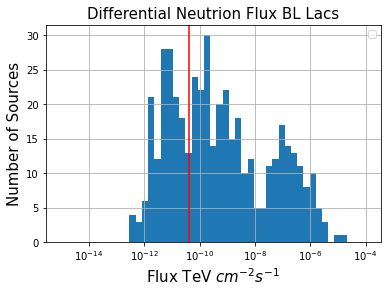

In [12]:
plt.hist(Diff_flux_1event['diff_flux'], bins=np.logspace(-15,-4))
plt.axvline(Diff_flux_1event['diff_flux'].median(),color='r')

plt.gca().set_xscale("log")
plt.xlabel('Flux TeV $cm^{-2} s^{-1}$',fontsize='15')
plt.ylabel('Number of Sources',fontsize='15')
plt.grid()
plt.title('Differential Neutrion Flux BL Lacs',fontsize='15')
plt.legend()

plt.show()

In [13]:
Diff_flux_1event = category_fsrq.loc[ category_fsrq['answer'] < 10**5]
Diff_flux_1event=Diff_flux_1event.reset_index()
for i in range(len(Diff_flux_1event)):
    if(30.0 <= Diff_flux_1event.loc[i,' Dec (J2000.0) _x'] < 90.0):
        Diff_flux_1event.loc[i,"zero"] = FindSorted1(data1['energy'], Diff_flux_1event.loc[i,'answer'],data1['area'])
    if(-5.0 <=  Diff_flux_1event.loc[i,' Dec (J2000.0) _x'] < 30.0):
        Diff_flux_1event.loc[i,"zero"] = FindSorted1(data2['energy'], Diff_flux_1event.loc[i,'answer'],data2['area'])
    if(-30.0 <=  Diff_flux_1event.loc[i,' Dec (J2000.0) _x'] < -5.0):
        Diff_flux_1event.loc[i,"zero"] = FindSorted1(data3['energy'], Diff_flux_1event.loc[i,'answer'],data3['area'])
    if(-90.0 <=  Diff_flux_1event.loc[i,' Dec (J2000.0) _x'] < -30.0):
        Diff_flux_1event.loc[i,"zero"] = FindSorted1(data4['energy'], Diff_flux_1event.loc[i,'answer'],data4['area'])    


Diff_flux_1event['diff_flux'] = Diff_flux_1event['answer']/(10000*Diff_flux_1event['zero']*(3.45*10**(8)))

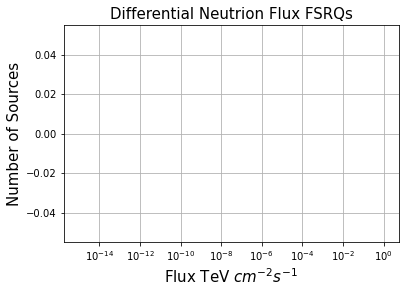

In [14]:
plt.hist(Diff_flux_1event['diff_flux'], bins=np.logspace(-15,0))
plt.axvline(Diff_flux_1event['diff_flux'].median(),color='r')

plt.gca().set_xscale("log")
plt.xlabel('Flux TeV $cm^{-2} s^{-1}$',fontsize='15')
plt.ylabel('Number of Sources',fontsize='15')
plt.grid()
plt.title('Differential Neutrion Flux FSRQs',fontsize='15')
plt.show()

In [15]:
k = (category_fsrq['answer']/(3.4*10**(8)*10*10000))
l = (category_fsrq['answer']/(3.4*10**(8)*1000*10000))

No handles with labels found to put in legend.


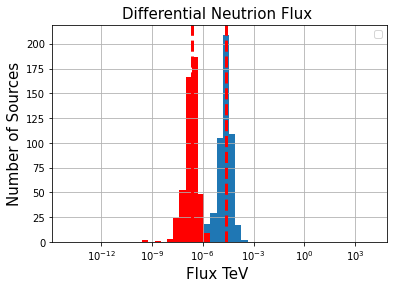

In [16]:

plt.hist(k, bins=np.logspace(-14,4))
plt.axvline(k.median(), color='r', linestyle='dashed', linewidth=3)
plt.hist(l, bins=np.logspace(-14,4),color='r')#, bins=np.logspace(np.log10(100.0),np.log10(1000000.0), 50))
plt.axvline(l.median(), color='r', linestyle='dashed', linewidth=3)

plt.gca().set_xscale("log")
plt.xlabel('Flux TeV ',fontsize='15')
plt.ylabel('Number of Sources',fontsize='15')
plt.grid()
plt.title('Differential Neutrion Flux ',fontsize='15')
plt.legend()

plt.show()

In [17]:
k

2       0.000012
3       0.000029
9       0.000061
10      0.000012
11      0.000013
          ...   
1397    0.000012
1400    0.000040
1401    0.000015
1403    0.000046
1405    0.000026
Name: answer, Length: 535, dtype: float32

In [18]:
category_fsrq['answer']

2       4.152396e+08
3       9.716519e+08
9       2.081491e+09
10      4.175670e+08
11      4.503170e+08
            ...     
1397    3.982444e+08
1400    1.363613e+09
1401    5.089784e+08
1403    1.562977e+09
1405    8.862558e+08
Name: answer, Length: 535, dtype: float32

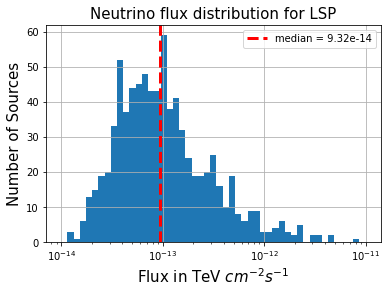

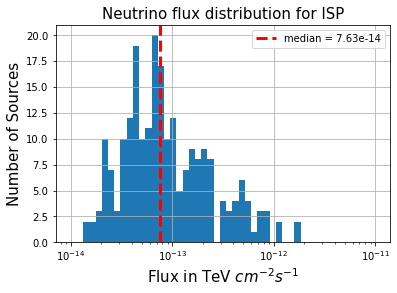

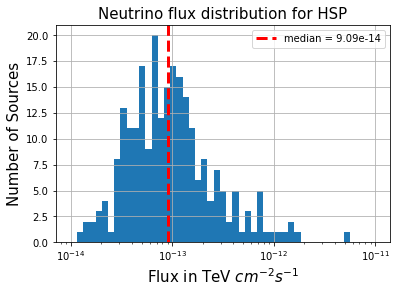

In [19]:
category_bll_lsp=bz_4lac.loc[bz_4lac['SED_class']=='LSP']

plt.hist(0.624*category_bll_lsp['total neutrino flux'],bins=np.logspace(-14,-11, 50))
plt.axvline(0.642*category_bll_lsp['total neutrino flux'].median(), color='r', linestyle='dashed', linewidth=3,label='median = 9.32e-14')
plt.gca().set_xscale("log")
plt.xlabel('Flux in TeV $cm^{-2} s^{-1}$',fontsize='15')
plt.ylabel('Number of Sources',fontsize='15')
plt.grid()
plt.legend()
plt.title('Neutrino flux distribution for LSP',fontsize='15')
plt.show()

category_bll_isp=bz_4lac.loc[bz_4lac['SED_class']=='ISP']

plt.hist(0.624*category_bll_isp['total neutrino flux'],bins=np.logspace(-14,-11, 50))
plt.axvline(0.642*category_bll_isp['total neutrino flux'].median(), color='r', linestyle='dashed', linewidth=3,label='median = 7.63e-14')
plt.gca().set_xscale("log")
plt.xlabel('Flux in TeV $cm^{-2} s^{-1}$',fontsize='15')
plt.ylabel('Number of Sources',fontsize='15')
plt.grid()
plt.legend()
plt.title('Neutrino flux distribution for ISP',fontsize='15')
plt.show()

category_bll_hsp=bz_4lac.loc[bz_4lac['SED_class']=='HSP']

plt.hist(0.624*category_bll_hsp['total neutrino flux'],bins=np.logspace(-14,-11, 50))
plt.axvline(0.642*category_bll_hsp['total neutrino flux'].median(), color='r', linestyle='dashed', linewidth=3,label='median = 9.09e-14')
plt.gca().set_xscale("log")
plt.xlabel('Flux in TeV $cm^{-2} s^{-1}$',fontsize='15')
plt.ylabel('Number of Sources',fontsize='15')
plt.grid()
plt.legend()
plt.title('Neutrino flux distribution for HSP',fontsize='15')
plt.show()

In [20]:
bz_4lac[' X-ray flux0.1-2.4 keV(1.e-12 cgs) '] = pd.to_numeric(bz_4lac[' X-ray flux0.1-2.4 keV(1.e-12 cgs) '],errors='coerce')
bz_4lac[' X-ray flux d. @ 1keV (μJy) ']=bz_4lac[' X-ray flux0.1-2.4 keV(1.e-12 cgs) ']*0.64
bz_4lac[' X-ray flux d. @ 1keV (μJy) ']=bz_4lac[' X-ray flux0.1-2.4 keV(1.e-12 cgs) ']*0.64*(10**(-23))*0.33*2.4*(10**11)

In [21]:
category_bll_lsp=bz_4lac.loc[bz_4lac['SED_class']=='LSP']
category_bll_isp=bz_4lac.loc[bz_4lac['SED_class']=='ISP']
category_bll_hsp=bz_4lac.loc[bz_4lac['SED_class']=='HSP']

2.1288959999999999e-13
1
2.8892159999999996e-13
2
1.2469248e-12
3


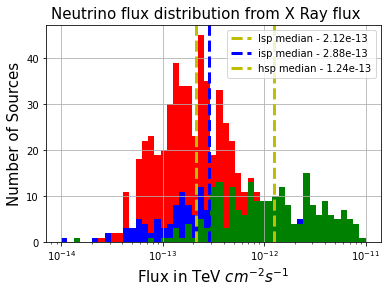

In [22]:
print(category_bll_lsp[' X-ray flux d. @ 1keV (μJy) '].median())
print('1')
plt.hist(category_bll_lsp[' X-ray flux d. @ 1keV (μJy) '],color='r',bins=np.logspace(-14,-11, 50)) #50MeV to 300GeV 
plt.axvline(category_bll_lsp[' X-ray flux d. @ 1keV (μJy) '].median(), color='y', linestyle='dashed', linewidth=3,label='lsp median - 2.12e-13')

plt.gca().set_xscale("log")
plt.xlabel('Flux in TeV $cm^{-2} s^{-1}$',fontsize='15')
plt.ylabel('Number of Sources',fontsize='15')
plt.grid()
plt.legend()
plt.title('Neutrino flux distribution from X Ray flux   ',fontsize='15')

#------------------------------------------------------------
print(category_bll_isp[' X-ray flux d. @ 1keV (μJy) '].median())
print('2')
plt.hist(category_bll_isp[' X-ray flux d. @ 1keV (μJy) '], color='b',bins=np.logspace(-14,-11, 50)) #50MeV to 300GeV 
plt.axvline(category_bll_isp[' X-ray flux d. @ 1keV (μJy) '].median(), color='b', linestyle='dashed', linewidth=3,label='isp median - 2.88e-13')

plt.gca().set_xscale("log")
plt.xlabel('Flux in TeV $cm^{-2} s^{-1}$',fontsize='15')
plt.ylabel('Number of Sources',fontsize='15')
plt.grid()
plt.legend()
plt.title('Neutrino flux distribution from X Ray flux   ',fontsize='15')
#-------------------------------------------------------------
print(category_bll_hsp[' X-ray flux d. @ 1keV (μJy) '].median())
print("3")
plt.hist(category_bll_hsp[' X-ray flux d. @ 1keV (μJy) '],color='g',bins=np.logspace(-14,-11, 50)) #50MeV to 300GeV 
plt.axvline(category_bll_hsp[' X-ray flux d. @ 1keV (μJy) '].median(), color='y', linestyle='dashed', linewidth=3,label='hsp median - 1.24e-13')

plt.gca().set_xscale("log")
plt.xlabel('Flux in TeV $cm^{-2} s^{-1}$',fontsize='15')
plt.ylabel('Number of Sources',fontsize='15')
plt.grid()
plt.legend()
plt.title('Neutrino flux distribution from X Ray flux   ',fontsize='15')
plt.show()

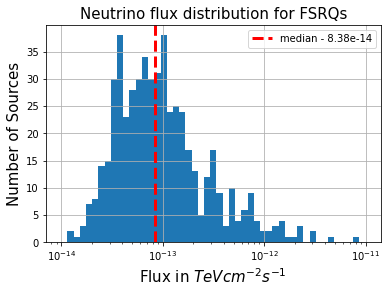

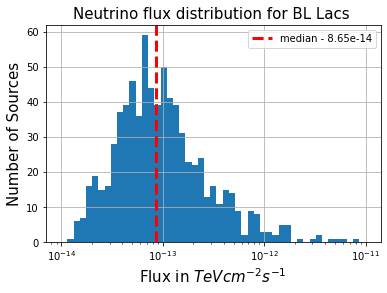

In [23]:
plt.hist(0.624*category_fsrq['total neutrino flux'],bins=np.logspace(-14,-11, 50))
plt.axvline(0.624*category_fsrq['total neutrino flux'].median(), color='r', linestyle='dashed', linewidth=3,label='median - 8.38e-14')
plt.gca().set_xscale("log")
plt.xlabel('Flux in $TeV cm^{-2} s^{-1}$ ',fontsize='15')
plt.ylabel('Number of Sources',fontsize='15')
plt.grid()
plt.title('Neutrino flux distribution for FSRQs',fontsize='15')
plt.legend()
plt.show()

plt.hist(0.624*category_bll['total neutrino flux'],bins=np.logspace(-14,-11, 50))
plt.axvline(0.624*category_bll['total neutrino flux'].median(), color='r', linestyle='dashed', linewidth=3,label='median - 8.65e-14')
plt.gca().set_xscale("log")
plt.xlabel('Flux in $TeV cm^{-2} s^{-1}$ ',fontsize='15')
plt.ylabel('Number of Sources',fontsize='15')
plt.grid()
plt.title('Neutrino flux distribution for BL Lacs ',fontsize='15')
plt.legend()
plt.show()

In [24]:
bz_4lac_lsp=bz_4lac.loc[bz_4lac['SED_class']=='LSP']

bz_4lac_isp=bz_4lac.loc[bz_4lac['SED_class']=='ISP']

bz_4lac_hsp=bz_4lac.loc[bz_4lac['SED_class']=='HSP']

df = pd.read_csv('e3_sensitivity.csv')
df1 = pd.read_csv('e2_sensitivity_datapoints.csv')
df2 = pd.read_csv('3cubed_90.csv')
df3 = pd.read_csv('esquared_90.csv')


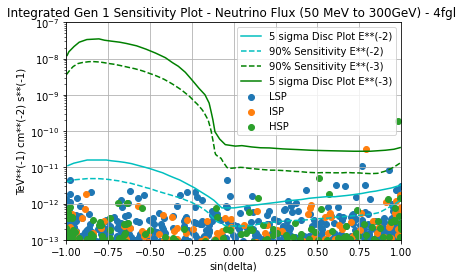

In [25]:
plt.ylim(10**(-13),10**(-7))
plt.xlim(-1.0,1.0)

plt.yscale("log")
plt.title('Integrated Gen 1 Sensitivity Plot - Neutrino Flux (50 MeV to 300GeV) - 4fgl ')

plt.xlabel('sin(delta)')
plt.ylabel('TeV**(-1) cm**(-2) s**(-1)')



plt.plot(df['x'],df[' y'],'c',label='5 sigma Disc Plot E**(-2)')
plt.plot(df3['x'],df3['y'],'--c',label='90% Sensitivity E**(-2)')

plt.plot(df2['x'],df2['y'],'--g',label='90% Sensitivity E**(-3)')

plt.plot(df1['x'],df1['y'],'g',label='5 sigma Disc Plot E**(-3)')
plt.scatter(np.sin(bz_4lac_lsp[' Dec (J2000.0) _x']),0.624*bz_4lac_lsp['total neutrino flux'],label='LSP');
plt.scatter(np.sin(bz_4lac_isp[' Dec (J2000.0) _x']),0.624*bz_4lac_isp['total neutrino flux'],label='ISP');
plt.scatter(np.sin(bz_4lac_hsp[' Dec (J2000.0) _x']),0.624*bz_4lac_hsp['total neutrino flux'],label='HSP');

#fig, ax = plt.subplots()
plt.legend();
plt.grid()
plt.show()

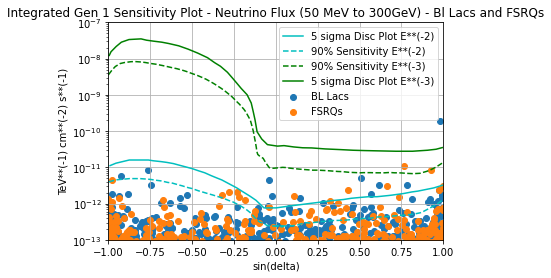

In [26]:
plt.ylim(10**(-13),10**(-7))
plt.xlim(-1.0,1.0)

plt.yscale("log")
plt.title('Integrated Gen 1 Sensitivity Plot - Neutrino Flux (50 MeV to 300GeV) - Bl Lacs and FSRQs')

plt.xlabel('sin(delta)')
plt.ylabel('TeV**(-1) cm**(-2) s**(-1)')



plt.plot(df['x'],df[' y'],'c',label='5 sigma Disc Plot E**(-2)')
plt.plot(df3['x'],df3['y'],'--c',label='90% Sensitivity E**(-2)')

plt.plot(df2['x'],df2['y'],'--g',label='90% Sensitivity E**(-3)')

plt.plot(df1['x'],df1['y'],'g',label='5 sigma Disc Plot E**(-3)')
plt.scatter(np.sin(category_bll[' Dec (J2000.0) _x']),0.624*category_bll['total neutrino flux'],label='BL Lacs');
plt.scatter(np.sin(category_fsrq[' Dec (J2000.0) _x']),0.624*category_fsrq['total neutrino flux'],label='FSRQs');
plt.legend();

plt.grid()
plt.show()

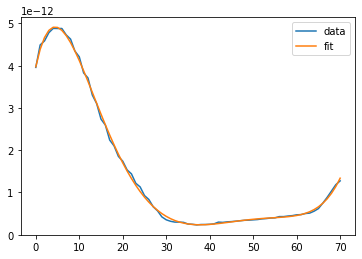

In [27]:
from scipy.optimize import curve_fit


import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-1.0,1.0,71)


poly1 = np.polyfit(x, df3['y'], deg=7)

fig, ax = plt.subplots()
ax.plot(df3['y'], label='data')
#ax.plot(np.polyval(poly, x), label='fit')
ax.plot(np.polyval(poly1, x), label='fit')
ax.legend()

In [28]:
bz_4lac_lsp_new = bz_4lac_lsp.loc[(0.624*bz_4lac_lsp['total neutrino flux'])>np.polyval(poly1, np.sin(bz_4lac_lsp[' Dec (J2000.0) _x']))] #lsp 89 survive out of 810 - 10.98%
bz_4lac_hsp_new = bz_4lac_hsp.loc[(0.624*bz_4lac_hsp['total neutrino flux'])>np.polyval(poly1, np.sin(bz_4lac_hsp[' Dec (J2000.0) _x']))] #hsp 20 survive out of 243 -  8.23% 
bz_4lac_isp_new = bz_4lac_isp.loc[(0.624*bz_4lac_isp['total neutrino flux'])>np.polyval(poly1, np.sin(bz_4lac_isp[' Dec (J2000.0) _x']))] #isp 21 survive out of 227 - 9.25% 
category_bll_new = category_bll.loc[(0.624*category_bll['total neutrino flux'])>np.polyval(poly1, np.sin(category_bll[' Dec (J2000.0) _x']))] #Bl Lac 78 survive out of 762 - 10.23% 
category_fsrq_new = category_fsrq.loc[(0.624*category_fsrq['total neutrino flux'])>np.polyval(poly1, np.sin(category_fsrq[' Dec (J2000.0) _x']))] #FSRQs 56 survive out of 535 - 10.46% 

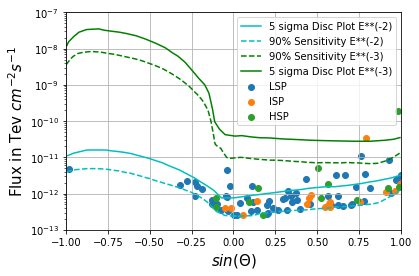

In [29]:
plt.ylim(10**(-13),10**(-7))
plt.xlim(-1.0,1.0)

plt.yscale("log")
#plt.title('Ice_Cube Sensitivity Plot - Neutrino Flux (50 MeV to 300GeV) - LSP')

plt.xlabel('$sin({\Theta})$',fontsize='15')
plt.ylabel('Flux in Tev $cm^{-2} s^{-1}$',fontsize='15')


plt.plot(df['x'],df[' y'],'c',label='5 sigma Disc Plot E**(-2)')
plt.plot(df3['x'],df3['y'],'--c',label='90% Sensitivity E**(-2)')

plt.plot(df2['x'],df2['y'],'--g',label='90% Sensitivity E**(-3)')

plt.plot(df1['x'],df1['y'],'g',label='5 sigma Disc Plot E**(-3)')
plt.scatter(np.sin(bz_4lac_lsp_new[' Dec (J2000.0) _x']),0.642*bz_4lac_lsp_new['total neutrino flux'],label='LSP');
plt.scatter(np.sin(bz_4lac_isp_new[' Dec (J2000.0) _x']),0.642*bz_4lac_isp_new['total neutrino flux'],label='ISP');
plt.scatter(np.sin(bz_4lac_hsp_new[' Dec (J2000.0) _x']),0.642*bz_4lac_hsp_new['total neutrino flux'],label='HSP');

#fig, ax = plt.subplots()
plt.legend();
plt.grid()
plt.show()

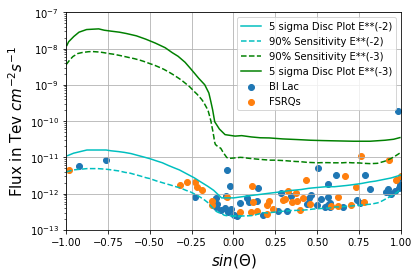

In [30]:
plt.ylim(10**(-13),10**(-7))
plt.xlim(-1.0,1.0)

plt.yscale("log")
#plt.title('Ice_Cube Sensitivity Plot - Neutrino Flux (50 MeV to 300GeV) - LSP')

plt.xlabel('$sin({\Theta})$',fontsize='15')
plt.ylabel('Flux in Tev $cm^{-2} s^{-1}$',fontsize='15')



plt.plot(df['x'],df[' y'],'c',label='5 sigma Disc Plot E**(-2)')
plt.plot(df3['x'],df3['y'],'--c',label='90% Sensitivity E**(-2)')

plt.plot(df2['x'],df2['y'],'--g',label='90% Sensitivity E**(-3)')

plt.plot(df1['x'],df1['y'],'g',label='5 sigma Disc Plot E**(-3)')
plt.scatter(np.sin(category_bll_new[' Dec (J2000.0) _x']),0.624*category_bll_new['total neutrino flux'],label='Bl Lac');
plt.scatter(np.sin(category_fsrq_new[' Dec (J2000.0) _x']),0.624*category_fsrq_new['total neutrino flux'],label='FSRQs');

#fig, ax = plt.subplots()
plt.legend();
plt.grid()
plt.show()

In [31]:
def neutrino_flux(gammaray_flux,one_to , neutrino_sed):
    E2_mu = 10000.0
    E1_mu = 30.0
    k = (1+one_to)/(E2_mu**(1+one_to) - E1_mu**(1+one_to))
    c = gammaray_flux*k
    return(c*(neutrino_sed**(one_to)))

<ipython-input-32-b7d33e8a5425>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_bll['final_thing'] = neutrino_flux(category_bll['total neutrino flux']*0.624,-2.0,category_bll['if_BLLac'])


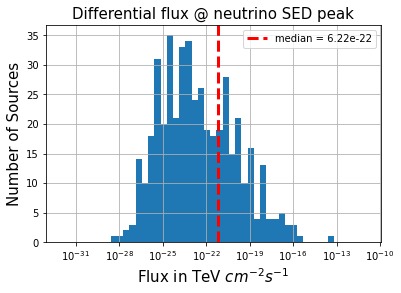

In [32]:
category_bll['final_thing'] = neutrino_flux(category_bll['total neutrino flux']*0.624,-2.0,category_bll['if_BLLac'])
#category_bll_new = category_bll.loc[category_bll['if_BLLac'] < 10000.0]
#category_bll.loc[(category_bll['final_thing'] > 10**-20), ['final_thing']].plot(kind='hist',logx=True,bins=np.logspace(-20,-11, 50))
plt.axvline(category_bll['final_thing'].median(), color='r', linestyle='dashed', linewidth=3,label='median = 6.22e-22')



plt.xscale("log")
plt.title('Differential flux @ neutrino SED peak',fontsize='15')

plt.xlabel('Flux in TeV $cm^{-2}s^{-1}$',fontsize='15')
plt.ylabel('Number of Sources',fontsize='15')

plt.hist(category_bll['final_thing'],bins=np.logspace(-32,-11, 50));
plt.legend()
plt.grid()
plt.show()

In [33]:
#category_bll['final_thing'] = neutrino_flux(category_bll['total neutrino flux']*0.624,-1.59,category_bll['if_BLLac'])
#category_bll_new = category_bll.loc[category_bll['if_BLLac'] < 10000.0]
#category_bll_new['final_thing']
#category_bll.loc[(category_bll['final_thing'] > 10**-20), ['final_thing']].plot(kind='hist',logx=True,bins=np.logspace(-20,-11, 50))


<ipython-input-34-3d40470942eb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_fsrq['final_thing'] = neutrino_flux(category_fsrq['total neutrino flux']*0.624,-1.58,category_fsrq['if_FSRQ_BR'])


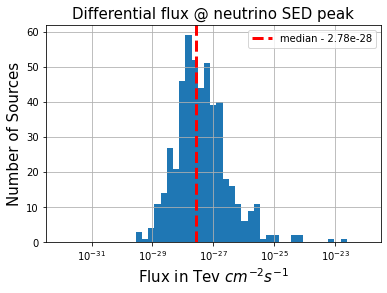

In [34]:
category_fsrq['final_thing'] = neutrino_flux(category_fsrq['total neutrino flux']*0.624,-1.58,category_fsrq['if_FSRQ_BR'])
plt.axvline(category_fsrq['final_thing'].median(), color='r', linestyle='dashed', linewidth=3,label='median - 2.78e-28')


plt.xscale("log")
plt.title('Differential flux @ neutrino SED peak',fontsize='15')

plt.xlabel('Flux in Tev $cm^{-2} s^{-1}$',fontsize='15')
plt.ylabel('Number of Sources',fontsize='15')

plt.hist(category_fsrq['final_thing'],bins=np.logspace(-32,-22, 50));
plt.legend()
plt.grid()
plt.show()

In [35]:
category_fsrq['final_thing'].median()

2.7863860195914055e-28

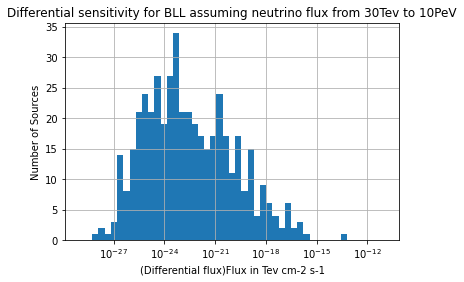

In [36]:
category_bll = category_bll.loc[category_bll['final_thing'].notnull()]

plt.xscale("log")
plt.title('Differential sensitivity for BLL assuming neutrino flux from 30Tev to 10PeV')

plt.xlabel('(Differential flux)Flux in Tev cm-2 s-1')
plt.ylabel('Number of Sources')

plt.hist(category_bll['final_thing'],bins=np.logspace(-29,-11, 50));

plt.grid()
plt.show()

In [37]:
#fsrq_BLR region 
def FSRQ_BLR(E_BL , delta_epsilon):
    a = 0.05*(0.5*(938.2))*delta_epsilon
    return(1000*a/E_BL)

In [38]:

list = [3.6*10**-6 , 0.0006 , 100.0, 1000.0, 2000.0] #3hsp has 1KeV other values are for BZCat
#lists = [1.0,2.0,3.0,4.0]
arr = np.array(list)

BLR_region = FSRQ_BLR(arr,0.34)


In [39]:
BLR_region

array([2.21519444e+09, 1.32911667e+07, 7.97470000e+01, 7.97470000e+00,
       3.98735000e+00])

In [40]:
def neutrino_flux2(gammaray_flux,gamma , neutrino_sed):
    time = 3.15*10**8
    effectivearea = 10**7
    E2_mu = 10000.0
    E1_mu = 30.0
    k = (2-gamma)/(E2_mu**(2-gamma) - E1_mu**(2-gamma))
    c = gammaray_flux*k*time*effectivearea
    return(c*(neutrino_sed**(-gamma)))

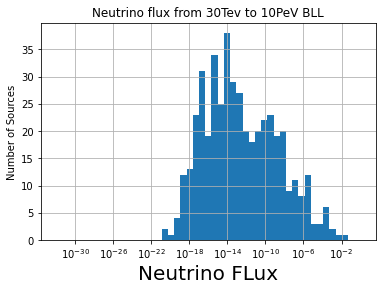

In [41]:
category_bll['final_neutrinoflux'] = neutrino_flux2(category_bll['total neutrino flux']*0.624,3,category_bll['if_BLLac'])
plt.xscale("log")
plt.title('Neutrino flux from 30Tev to 10PeV BLL')

plt.xlabel('Neutrino FLux', fontsize = 20)
plt.ylabel('Number of Sources')

plt.hist(category_bll['final_neutrinoflux'],bins=np.logspace(-32,0, 50));

plt.grid()
plt.show()

<ipython-input-42-68f8688fc009>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_fsrq['final_neutrinoflux'] = neutrino_flux2(category_fsrq['total neutrino flux']*0.624,3,category_fsrq['if_BLLac'])


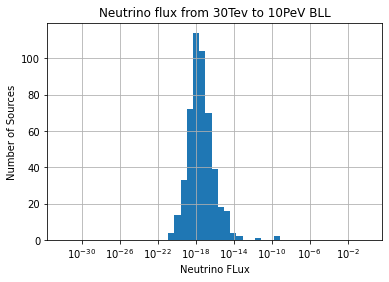

In [42]:
category_fsrq['final_neutrinoflux'] = neutrino_flux2(category_fsrq['total neutrino flux']*0.624,3,category_fsrq['if_BLLac'])
plt.xscale("log")
plt.title('Neutrino flux from 30Tev to 10PeV BLL')

plt.xlabel('Neutrino FLux')
plt.ylabel('Number of Sources')

plt.hist(category_fsrq['final_neutrinoflux'],bins=np.logspace(-32,0, 50));

plt.grid()
plt.show()

In [43]:
bz_4lac[' X-ray flux0.1-2.4 keV(1.e-12 cgs) ']=bz_4lac[' X-ray flux0.1-2.4 keV(1.e-12 cgs) '].astype(float)

In [44]:
bz_4lac[' X-ray flux d. @ 1keV (μJy) ']=bz_4lac[' X-ray flux0.1-2.4 keV(1.e-12 cgs) ']*0.64

In [45]:
bz_4lac[' X-ray flux d. @ 1keV (μJy) ']=bz_4lac[' X-ray flux0.1-2.4 keV(1.e-12 cgs) ']*0.64*(10**(-23))*0.33*2.4*(10**11)

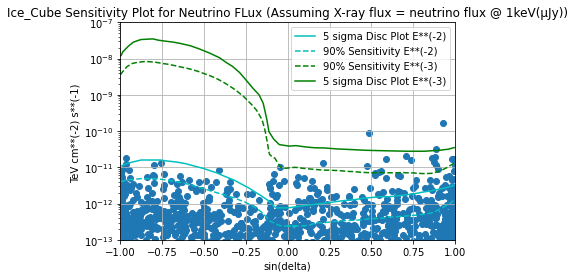

In [47]:

plt.ylim(10**(-13),10**(-7))
plt.xlim(-1.0,1.0)

plt.yscale("log")
plt.title('Ice_Cube Sensitivity Plot for Neutrino FLux (Assuming X-ray flux = neutrino flux @ 1keV(μJy))')

plt.xlabel('sin(delta)')
plt.ylabel('TeV cm**(-2) s**(-1) ')
plt.plot(df['x'],df[' y'],'c',label='5 sigma Disc Plot E**(-2)')
plt.plot(df3['x'],df3['y'],'--c',label='90% Sensitivity E**(-2)')
plt.plot(df2['x'],df2['y'],'--g',label='90% Sensitivity E**(-3)')
plt.plot(df1['x'],df1['y'],'g',label='5 sigma Disc Plot E**(-3)')

plt.scatter(np.sin(bz_4lac[' Dec (J2000.0) _x']),bz_4lac[' X-ray flux d. @ 1keV (μJy) ']);
plt.legend();

plt.grid()
plt.show()

In [48]:
bz_4lac

,index_x,index_x,id _x,BZCAT5 Source name,Other name,BZCAT name,RA (J2000.0) _x,Dec (J2000.0) _x,Redshift,Redshiftflag,...,Variability_Index,Frac_Variability,Unc_Frac_Variability,Highest_energy,nu_syn_peak,nu_syn_peak_in_eV,if_BLLac,if_FSRQ_BR,answer,X-ray flux d. @ 1keV (μJy)
0,0,3,4,5BZBJ0001-0746,CRATESJ000117-074633,BZBJ0001-0746,0.32504,-7.77408,NaN,NaN,...,16.869194,0.211933,0.101339,86.975197,9.120108e+13,0.377116,0.000000e+00,2.121361e+08,0.000000e+00,1.774080e-13
1,1,8,9,5BZBJ0004-1148,CGRaBSJ0004-1148,NaN,1.02033,-11.81611,NaN,NaN,...,4.723145,0.000000,10.000000,10.839500,2.454709e+12,0.010150,3.006079e+07,7.881602e+09,1.477047e+09,NaN
2,2,10,11,5BZQJ0004-4736,PKS 0002-478,BZQJ0004-4736,1.14850,-47.60542,0.884,NaN,...,123.413033,0.832656,0.234911,10.000000,1.318257e+13,0.054510,8.450937e+06,1.467623e+09,4.152396e+08,4.308480e-13
3,3,14,15,5BZQJ0005+3820,S40003+380,BZQJ0005+3820,1.48825,38.33756,0.229,NaN,...,23.272005,0.322573,0.121076,10.000000,1.318257e+13,0.054510,1.977501e+07,1.467623e+09,9.716519e+08,3.801600e-13
4,4,15,16,5BZBJ0006-0623,PKS0003-066,BZQJ0006-0623,1.55788,-6.39311,0.347,NaN,...,18.205976,0.614334,0.342016,10.000000,8.317638e+12,0.034393,2.609068e+07,2.326025e+09,1.281974e+09,4.156416e-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1402,1500,3549,3550,5BZBJ2357-0152,PKS 2354-021,BZBJ2357-0152,359.35475,-1.87097,0.812,NaN,...,27.711256,0.661898,0.227997,10.000000,1.096478e+13,0.045339,1.093715e+07,1.764471e+09,5.374004e+08,NaN
1403,1501,3552,3553,5BZQJ2357-5311,PKS2355-534,BZQJ2357-5311,359.47196,-53.18714,1.006,NaN,...,213.767548,1.156340,0.317697,16.953899,3.076097e+12,0.012720,3.180964e+07,6.289476e+09,1.562977e+09,7.856640e-13
1404,1502,3553,3554,5BZQJ2358-4555,PKS2355-461,BZQJ2358-4555,359.50896,-45.92181,0.444,NaN,...,23.737629,0.496924,0.185568,10.000000,5.754399e+12,0.023794,3.281604e+07,3.362130e+09,1.612427e+09,NaN
1405,1504,3557,3558,5BZQJ2358+3922,S4 2356+39,BZQJ2358+3922,359.74942,39.37453,1.201,NaN,...,19.993589,0.797089,0.304179,10.000000,4.518559e+12,0.018684,1.803704e+07,4.281683e+09,8.862558e+08,2.027520e-13


In [49]:
bz_4lac_x_lsp=bz_4lac.loc[bz_4lac['SED_class']=='LSP']
bz_4lac_x_isp=bz_4lac.loc[bz_4lac['SED_class']=='ISP']
bz_4lac_x_hsp=bz_4lac.loc[bz_4lac['SED_class']=='HSP']
bz_4lac_x_fsrq=bz_4lac.loc[bz_4lac['CLASS']=='fsrq']
bz_4lac_x_bllac=bz_4lac.loc[bz_4lac['CLASS']=='bll']

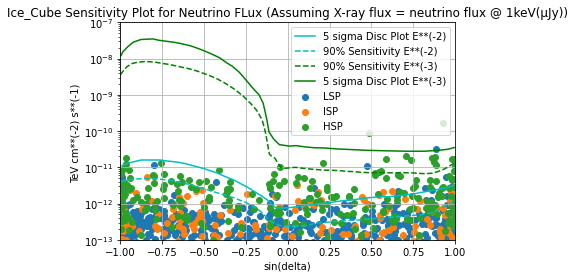

In [50]:

plt.ylim(10**(-13),10**(-7))
plt.xlim(-1.0,1.0)

plt.yscale("log")
plt.title('Ice_Cube Sensitivity Plot for Neutrino FLux (Assuming X-ray flux = neutrino flux @ 1keV(μJy))')

plt.xlabel('sin(delta)')
plt.ylabel('TeV cm**(-2) s**(-1) ')
plt.plot(df['x'],df[' y'],'c',label='5 sigma Disc Plot E**(-2)')
plt.plot(df3['x'],df3['y'],'--c',label='90% Sensitivity E**(-2)')
plt.plot(df2['x'],df2['y'],'--g',label='90% Sensitivity E**(-3)')
plt.plot(df1['x'],df1['y'],'g',label='5 sigma Disc Plot E**(-3)')

plt.scatter(np.sin(bz_4lac_x_lsp[' Dec (J2000.0) _x']),bz_4lac_x_lsp[' X-ray flux d. @ 1keV (μJy) '],label='LSP')
plt.scatter(np.sin(bz_4lac_x_isp[' Dec (J2000.0) _x']),bz_4lac_x_isp[' X-ray flux d. @ 1keV (μJy) '],label='ISP')
plt.scatter(np.sin(bz_4lac_x_hsp[' Dec (J2000.0) _x']),bz_4lac_x_hsp[' X-ray flux d. @ 1keV (μJy) '],label='HSP')

plt.legend();
plt.grid()
plt.show()

In [52]:
bz_4lac_x_lsp = bz_4lac_lsp.loc[(bz_4lac_lsp[' X-ray flux d. @ 1keV (μJy) '])>np.polyval(poly1, np.sin(bz_4lac_lsp[' Dec (J2000.0) _x']))] #lsp 89 survive out of 810 - 10.98%


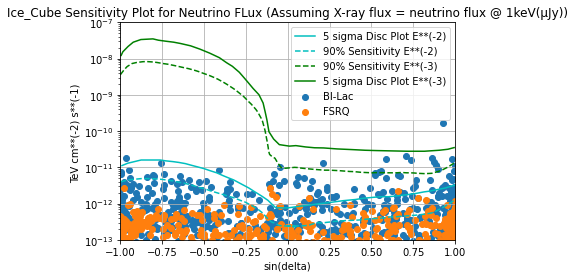

In [53]:
plt.ylim(10**(-13),10**(-7))
plt.xlim(-1.0,1.0)

plt.yscale("log")
plt.title('Ice_Cube Sensitivity Plot for Neutrino FLux (Assuming X-ray flux = neutrino flux @ 1keV(μJy))')

plt.xlabel('sin(delta)')
plt.ylabel('TeV cm**(-2) s**(-1) ')
plt.plot(df['x'],df[' y'],'c',label='5 sigma Disc Plot E**(-2)')
plt.plot(df3['x'],df3['y'],'--c',label='90% Sensitivity E**(-2)')
plt.plot(df2['x'],df2['y'],'--g',label='90% Sensitivity E**(-3)')
plt.plot(df1['x'],df1['y'],'g',label='5 sigma Disc Plot E**(-3)')

plt.scatter(np.sin(bz_4lac_x_bllac[' Dec (J2000.0) _x']),bz_4lac_x_bllac[' X-ray flux d. @ 1keV (μJy) '],label='Bl-Lac')
plt.scatter(np.sin(bz_4lac_x_fsrq[' Dec (J2000.0) _x']),bz_4lac_x_fsrq[' X-ray flux d. @ 1keV (μJy) '],label='FSRQ')

plt.legend();
plt.grid()
plt.show()

In [54]:
bz_4lac_x_hsp # 189 bllac # 36 fsrq  # 70 lsp #34 isp # 133 hsp 

,index_x,index_x,id _x,BZCAT5 Source name,Other name,BZCAT name,RA (J2000.0) _x,Dec (J2000.0) _x,Redshift,Redshiftflag,...,Variability_Index,Frac_Variability,Unc_Frac_Variability,Highest_energy,nu_syn_peak,nu_syn_peak_in_eV,if_BLLac,if_FSRQ_BR,answer,X-ray flux d. @ 1keV (μJy)
8,8,26,27,5BZBJ0009+5030,2FGLJ0009.1+5030,NaN,2.34488,50.50794,NaN,NaN,...,132.097107,0.388967,0.109684,72.761703,1.258925e+15,5.205657,0.000000,1.536790e+07,0.000000e+00,1.216512e-13
14,14,40,41,5BZGJ0013-1854,A0011-1910,BZBJ0013-1854,3.48350,-18.90181,0.095,NaN,...,2.608108,0.000000,10.000000,37.216900,8.709636e+16,360.143463,3771.502880,2.221337e+05,1.853140e+05,3.289651e-12
16,16,42,43,5BZBJ0014-5022,BZBJ0014-5022,BZBJ0014-5022,3.54763,-50.37636,NaN,NaN,...,1.682419,0.000000,10.000000,26.053699,4.570882e+17,1890.059692,844.457539,4.232671e+04,4.149270e+04,3.538022e-12
30,31,63,64,5BZGJ0022+0006,1RXSJ002200.9+000659,BZBJ0022+0006,5.50396,0.11611,0.306,NaN,...,8.975574,0.000000,10.000000,353.833008,1.348963e+17,557.796204,1711.331756,1.434216e+05,8.408685e+04,5.119488e-13
40,41,88,89,5BZBJ0033-1921,SHBLJ003334.2-192133,BZBJ0033-1921,8.39317,-19.35914,NaN,NaN,...,27.173615,0.163089,0.058758,170.005997,7.079458e+15,29.273560,21456.988493,2.732842e+06,1.054296e+06,4.272998e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1371,1463,3455,3456,5BZBJ2322-4916,2FGLJ2323.0-4918,NaN,350.72679,-49.27503,NaN,NaN,...,24.766706,0.371870,0.147387,51.247601,4.168694e+15,17.237551,49597.799952,4.641030e+06,2.437004e+06,7.958016e-13
1377,1469,3465,3466,5BZBJ2325+1646,1WGAJ2325.6+1646,NaN,351.40879,16.77856,NaN,NaN,...,15.501444,0.640649,0.309708,27.310400,2.511886e+15,10.386650,0.000000,7.702194e+06,0.000000e+00,1.317888e-13
1380,1473,3473,3474,5BZBJ2329+3754,GB6B2326+3737,NaN,352.30946,37.90400,NaN,NaN,...,13.750117,0.240974,0.129787,142.132004,8.035261e+15,33.225807,30670.898012,2.407767e+06,1.507024e+06,6.792192e-13
1393,1488,3506,3507,5BZBJ2343+3439,1FGL_J2343.6+3437,BZBJ2343+3439,355.88992,34.66414,0.366,NaN,...,15.971925,0.371703,0.176238,72.659599,3.981072e+17,1646.173218,530.052860,4.859756e+04,2.604432e+04,2.752358e-12


In [55]:
category_bll['total neutrino flux']

0       3.521055e-14
1       1.411532e-13
4       6.746523e-14
5       1.685851e-13
6       8.789385e-14
            ...     
1393    1.200454e-12
1395    6.692237e-13
1399    4.017651e-14
1402    2.925337e-13
1406    8.909281e-14
Name: total neutrino flux, Length: 741, dtype: float64

In [56]:
k = neutrino_flux(1.200454e-12*0.624,-2.0,3.98)


In [57]:
BZ[' X-ray flux0.1-2.4 keV(1.e-12 cgs) ']=BZ[' X-ray flux0.1-2.4 keV(1.e-12 cgs) '].astype(float)
BZ[' X-ray flux d. @ 1keV (μJy) ']=BZ[' X-ray flux0.1-2.4 keV(1.e-12 cgs) ']*0.64
BZ[' X-ray flux d. @ 1keV (μJy) ']=BZ[' X-ray flux0.1-2.4 keV(1.e-12 cgs) ']*0.64*(10**(-23))*0.33*2.4*(10**11)

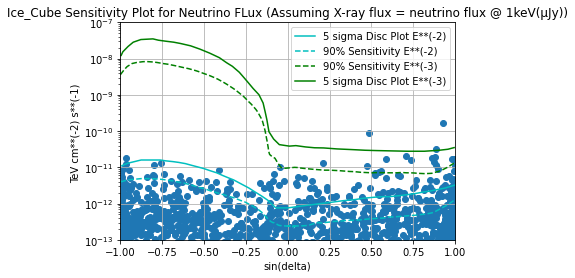

In [58]:

plt.ylim(10**(-13),10**(-7))
plt.xlim(-1.0,1.0)

plt.yscale("log")
plt.title('Ice_Cube Sensitivity Plot for Neutrino FLux (Assuming X-ray flux = neutrino flux @ 1keV(μJy))')

plt.xlabel('sin(delta)')
plt.ylabel('TeV cm**(-2) s**(-1) ')
plt.plot(df['x'],df[' y'],'c',label='5 sigma Disc Plot E**(-2)')
plt.plot(df3['x'],df3['y'],'--c',label='90% Sensitivity E**(-2)')
plt.plot(df2['x'],df2['y'],'--g',label='90% Sensitivity E**(-3)')
plt.plot(df1['x'],df1['y'],'g',label='5 sigma Disc Plot E**(-3)')

plt.scatter(np.sin(BZ[' Dec (J2000.0) ']),BZ[' X-ray flux d. @ 1keV (μJy) ']);
plt.legend();

plt.grid()
plt.show()

In [59]:
BZ.columns

Index(['index', 'id ', ' BZCAT5 Source name ', ' Other name ', ' BZCAT name ',
       ' RA (J2000.0) ', ' Dec (J2000.0) ', ' Redshift ', ' Redshiftflag ',
       ' Rmag ', ' Source classification ', ' Flux density 1.4/0.843GHz(mJy) ',
       ' Flux density 5.0GHz(mJy) ', ' Flux density143GHz(mJy) ',
       ' X-ray flux0.1-2.4 keV(1.e-12 cgs) ', ' Fermi flux1-100 GeV(ph/cm2/s)',
       ' X-ray flux d. @ 1keV (μJy) '],
      dtype='object')

In [60]:
category_bll=BZ.loc[BZ[' Source classification ']==' BL Lac '] #  BZ[' Source classification ']==' BL Lac-galaxy dominated ' ]
category_fsrq=BZ.loc[BZ[' Source classification ']==' QSO RLoud flat radio sp. ']

In [61]:
category_bll=BZ.loc[BZ[' Source classification ']==' BL Lac ' ]

In [62]:
category_bll

,index,id,BZCAT5 Source name,Other name,BZCAT name,RA (J2000.0),Dec (J2000.0),Redshift,Redshiftflag,Rmag,Source classification,Flux density 1.4/0.843GHz(mJy),Flux density 5.0GHz(mJy),Flux density143GHz(mJy),X-ray flux0.1-2.4 keV(1.e-12 cgs),Fermi flux1-100 GeV(ph/cm2/s),X-ray flux d. @ 1keV (μJy)
0,3,4,5BZBJ0001-0746,CRATESJ000117-074633,BZBJ0001-0746,0.32504,-7.77408,NaN,NaN,17.9,BL Lac,208,148,NaN,0.35,5e-10,1.774080e-13
1,8,9,5BZBJ0004-1148,CGRaBSJ0004-1148,NaN,1.02033,-11.81611,NaN,NaN,18.8,BL Lac,459,835,308,NaN,NaN,NaN
4,15,16,5BZBJ0006-0623,PKS0003-066,BZQJ0006-0623,1.55788,-6.39311,0.347,NaN,17.9,BL Lac,2051,2463,1212,0.82,NaN,4.156416e-13
5,20,21,5BZBJ0007+4712,RXJ00079+4712,BZBJ0007+4712,1.99988,47.20214,0.28,?,18.2,BL Lac,60,59,NaN,0.53,2.1e-9,2.686464e-13
6,22,23,5BZBJ0008-2339,1RXSJ000835.4-233917,BZBJ0008-2339,2.14742,-23.65772,0.147,NaN,16.8,BL Lac,36,NaN,NaN,2.42,3e-10,1.226650e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1491,3515,3516,5BZBJ2347+5142,1ES2344+514,BZBJ2347+5142,356.77017,51.70497,0.044,NaN,10.7,BL Lac,250,240,NaN,7.71,1.5e-9,3.908045e-12
1494,3529,3530,5BZBJ2352+1749,GB6J2352+1749,NaN,358.02429,17.82047,NaN,NaN,17.6,BL Lac,45,34,NaN,NaN,8e-10,NaN
1496,3535,3536,5BZBJ2353-3037,PKS2351-309,BZBJ2353-3037,358.44775,-30.63014,0.737,NaN,16.6,BL Lac,397,415,NaN,0.22,5e-10,1.115136e-13
1500,3549,3550,5BZBJ2357-0152,PKS 2354-021,BZBJ2357-0152,359.35475,-1.87097,0.812,NaN,19.4,BL Lac,233,242,NaN,NaN,NaN,NaN


In [63]:
plt.hist(0.624*category_fsrq[' Fermi flux1-100 GeV(ph/cm2/s)'],bins=np.logspace(-13,-7, 50))
plt.gca().set_xscale("log")
plt.xlabel('Flux in erg/cm2/s')
plt.ylabel('Number of Sources')
plt.grid()
plt.title('Neutrino flux distribution for fsrq - from gammarays 4fgl')
plt.show()

plt.hist(0.624*category_bll[' Fermi flux1-100 GeV(ph/cm2/s)'],bins=np.logspace(-13,-7, 50))
plt.gca().set_xscale("log")
plt.xlabel('Flux in erg/cm2/s')
plt.ylabel('Number of Sources')
plt.grid()
plt.title('Neutrino flux distribution for bll - from gammarays 4fgl')
plt.show()

TypeError: can't multiply sequence by non-int of type 'float'

In [65]:
BZ = pd.read_csv("romabzcat_full.csv")


In [66]:
BZ[' Fermi flux1-100 GeV(ph/cm2/s)'] = pd.to_numeric(BZ[' Fermi flux1-100 GeV(ph/cm2/s)'],errors='coerce')


In [67]:
k=BZ.loc[BZ[' Fermi flux1-100 GeV(ph/cm2/s)'].notnull()]

In [68]:
k[' Fermi flux1-100 GeV(ph/cm2/s)'] = pd.to_numeric(k[' Fermi flux1-100 GeV(ph/cm2/s)'],errors='coerce')


<ipython-input-68-8d7027d55a1f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  k[' Fermi flux1-100 GeV(ph/cm2/s)'] = pd.to_numeric(k[' Fermi flux1-100 GeV(ph/cm2/s)'],errors='coerce')


In [69]:
k=k.loc[k[' Fermi flux1-100 GeV(ph/cm2/s)'].notnull()]

In [70]:
k[' Fermi flux1-100 GeV(ph/cm2/s)']

3       5.000000e-10
10      9.000000e-10
14      1.000000e-09
20      2.100000e-09
22      3.000000e-10
            ...     
3529    8.000000e-10
3535    5.000000e-10
3545    6.000000e-10
3547    3.000000e-10
3558    6.000000e-10
Name:  Fermi flux1-100 GeV(ph/cm2/s), Length: 999, dtype: float64

TypeError: 'value' must be an instance of str or bytes, not a float

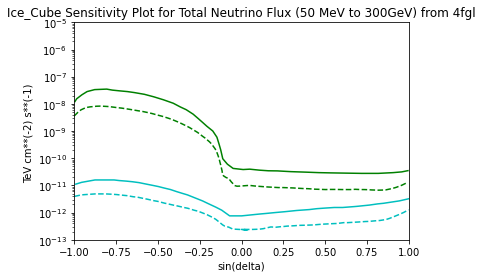

In [71]:

df = pd.read_csv('e3_sensitivity.csv')
df1 = pd.read_csv('e2_sensitivity_datapoints.csv')
df3 = pd.read_csv('esquared_90.csv')

plt.ylim(10**(-13),10**(-5))
plt.xlim(-1.0,1.0)

plt.yscale("log")
plt.title('Ice_Cube Sensitivity Plot for Total Neutrino Flux (50 MeV to 300GeV) from 4fgl')
plt.xlabel('sin(delta)')
plt.ylabel('TeV cm**(-2) s**(-1) ')
plt.plot(df['x'],df[' y'],'c',label='5 sigma Disc Plot E**(-2)')
plt.plot(df3['x'],df3['y'],'--c',label='90% Sensitivity E**(-2)')
plt.plot(df2['x'],df2['y'],'--g',label='90% Sensitivity E**(-3)')
plt.plot(df1['x'],df1['y'],'g',label='5 sigma Disc Plot E**(-3)')

plt.scatter(np.sin(category_bll[' Dec (J2000.0) ']),category_bll[' Fermi flux1-100 GeV(ph/cm2/s)'],label='BL-LAC');
plt.scatter(np.sin(category_fsrq[' Dec (J2000.0) ']),category_fsrq[' Fermi flux1-100 GeV(ph/cm2/s)'],label='FSRQ');

plt.legend()
plt.grid()
plt.show()

In [72]:
BZ[' X-ray flux0.1-2.4 keV(1.e-12 cgs) '] = pd.to_numeric(BZ[' X-ray flux0.1-2.4 keV(1.e-12 cgs) '],errors='coerce')
BZ[' X-ray flux d. @ 1keV (μJy) ']=BZ[' X-ray flux0.1-2.4 keV(1.e-12 cgs) ']*0.64
BZ[' X-ray flux d. @ 1keV (μJy) ']=BZ[' X-ray flux0.1-2.4 keV(1.e-12 cgs) ']*0.64*(10**(-23))*0.33*2.4*(10**11)

In [73]:
df = pd.read_csv('e3_sensitivity.csv')
df1 = pd.read_csv('e2_sensitivity_datapoints.csv')
df2 = pd.read_csv('3cubed_90.csv')
df3 = pd.read_csv('esquared_90.csv')

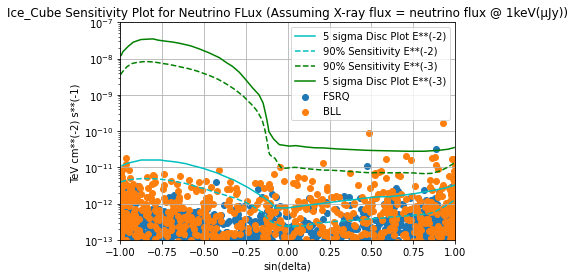

In [74]:
category_bll=BZ.loc[BZ[' Source classification ']==' BL Lac '] #  BZ[' Source classification ']==' BL Lac-galaxy dominated ' ]


category_fsrq=BZ.loc[BZ[' Source classification ']==' QSO RLoud flat radio sp. ']

plt.ylim(10**(-13),10**(-7))
plt.xlim(-1.0,1.0)

plt.yscale("log")
plt.title('Ice_Cube Sensitivity Plot for Neutrino FLux (Assuming X-ray flux = neutrino flux @ 1keV(μJy))')

plt.xlabel('sin(delta)')
plt.ylabel('TeV cm**(-2) s**(-1) ')
plt.plot(df['x'],df[' y'],'c',label='5 sigma Disc Plot E**(-2)')
plt.plot(df3['x'],df3['y'],'--c',label='90% Sensitivity E**(-2)')
plt.plot(df2['x'],df2['y'],'--g',label='90% Sensitivity E**(-3)')
plt.plot(df1['x'],df1['y'],'g',label='5 sigma Disc Plot E**(-3)')

plt.scatter(np.sin(category_fsrq[' Dec (J2000.0) ']),category_fsrq[' X-ray flux d. @ 1keV (μJy) '],label='FSRQ');
plt.scatter(np.sin(category_bll[' Dec (J2000.0) ']),category_bll[' X-ray flux d. @ 1keV (μJy) '],label='BLL');

plt.legend();

plt.grid()
plt.show()

In [75]:
category_fsrq_x = category_fsrq.loc[(category_fsrq[' X-ray flux d. @ 1keV (μJy) '])>np.polyval(poly1, np.sin(category_fsrq[' Dec (J2000.0) ']))] #lsp 89 survive out of 810 - 10.98%
category_bll_x = category_bll.loc[(category_bll[' X-ray flux d. @ 1keV (μJy) '])>np.polyval(poly1, np.sin(category_bll[' Dec (J2000.0) ']))] #lsp 89 survive out of 810 - 10.98%


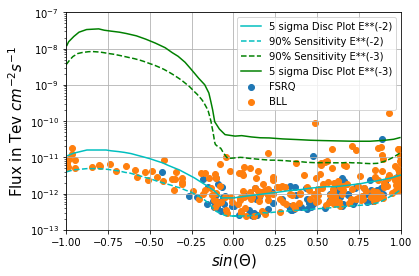

In [76]:
plt.ylim(10**(-13),10**(-7))
plt.xlim(-1.0,1.0)

plt.yscale("log")

plt.xlabel('$sin({\Theta})$',fontsize='15')
plt.ylabel('Flux in Tev $cm^{-2} s^{-1}$',fontsize='15')
plt.plot(df['x'],df[' y'],'c',label='5 sigma Disc Plot E**(-2)')
plt.plot(df3['x'],df3['y'],'--c',label='90% Sensitivity E**(-2)')
plt.plot(df2['x'],df2['y'],'--g',label='90% Sensitivity E**(-3)')
plt.plot(df1['x'],df1['y'],'g',label='5 sigma Disc Plot E**(-3)')

plt.scatter(np.sin(category_fsrq_x[' Dec (J2000.0) ']),category_fsrq_x[' X-ray flux d. @ 1keV (μJy) '],label='FSRQ');
plt.scatter(np.sin(category_bll_x[' Dec (J2000.0) ']),category_bll_x[' X-ray flux d. @ 1keV (μJy) '],label='BLL');

plt.legend();

plt.grid()
plt.show()

2.382336e-13
1
4.2577919999999997e-13
2
1.672704e-13
3


Text(0.5, 1.0, 'Neutrino flux distribution from X Ray flux   ')

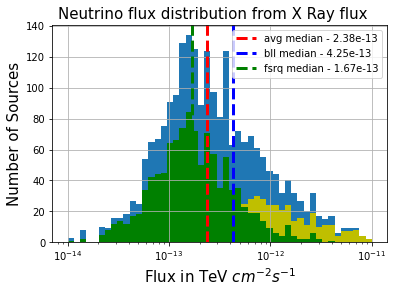

In [77]:
print(BZ[' X-ray flux d. @ 1keV (μJy) '].median())
print('1')
plt.hist(BZ[' X-ray flux d. @ 1keV (μJy) '],bins=np.logspace(-14,-11, 50)) #50MeV to 300GeV 
plt.axvline(BZ[' X-ray flux d. @ 1keV (μJy) '].median(), color='r', linestyle='dashed', linewidth=3,label='avg median - 2.38e-13')

plt.gca().set_xscale("log")
plt.xlabel('Flux in TeV $cm^{-2} s^{-1}$',fontsize='15')
plt.ylabel('Number of Sources',fontsize='15')
plt.grid()
plt.legend()
plt.title('Neutrino flux distribution from X Ray flux   ',fontsize='15')
#------------------------------------------------------------
print(category_bll[' X-ray flux d. @ 1keV (μJy) '].median())
print('2')
plt.hist(category_bll[' X-ray flux d. @ 1keV (μJy) '],color='y',bins=np.logspace(-14,-11, 50)) #50MeV to 300GeV 
plt.axvline(category_bll[' X-ray flux d. @ 1keV (μJy) '].median(), color='b', linestyle='dashed', linewidth=3,label='bll median - 4.25e-13')

plt.gca().set_xscale("log")
plt.xlabel('Flux in TeV $cm^{-2} s^{-1}$',fontsize='15')
plt.ylabel('Number of Sources',fontsize='15')
plt.grid()
plt.legend()
plt.title('Neutrino flux distribution from X Ray flux   ',fontsize='15')

#-------------------------------------------------------------
print(category_fsrq[' X-ray flux d. @ 1keV (μJy) '].median())
print("3")
plt.hist(category_fsrq[' X-ray flux d. @ 1keV (μJy) '],color='g',bins=np.logspace(-14,-11, 50)) #50MeV to 300GeV 
plt.axvline(category_fsrq[' X-ray flux d. @ 1keV (μJy) '].median(), color='g', linestyle='dashed', linewidth=3,label='fsrq median - 1.67e-13')

plt.gca().set_xscale("log")
plt.xlabel('Flux in TeV $cm^{-2} s^{-1}$',fontsize='15')
plt.ylabel('Number of Sources',fontsize='15')
plt.grid()
plt.legend()
plt.title('Neutrino flux distribution from X Ray flux   ',fontsize='15')

In [78]:
category_bll_x

,id,BZCAT5 Source name,Other name,BZCAT name,RA (J2000.0),Dec (J2000.0),Redshift,Redshiftflag,Rmag,Source classification,Flux density 1.4/0.843GHz(mJy),Flux density 5.0GHz(mJy),Flux density143GHz(mJy),X-ray flux0.1-2.4 keV(1.e-12 cgs),Fermi flux1-100 GeV(ph/cm2/s),X-ray flux d. @ 1keV (μJy)
15,16,5BZBJ0006-0623,PKS0003-066,BZQJ0006-0623,1.55788,-6.39311,0.347,,17.9,BL Lac,2051,2463,1212,0.82,NaN,4.156416e-13
24,25,5BZBJ0009+0628,1RXSJ000904.4+062828,BZBJ0009+0628,2.26633,6.47261,,,18.9,BL Lac,247,259,,0.55,5.000000e-10,2.787840e-13
42,43,5BZBJ0014-5022,BZBJ0014-5022,BZBJ0014-5022,3.54763,-50.37636,,,18.7,BL Lac,13,,,6.98,6.000000e-10,3.538022e-12
65,66,5BZBJ0022-1853,1FGL_J0022.2-1850,,5.53863,-18.89300,,,18.6,BL Lac,23,,,0.69,9.000000e-10,3.497472e-13
88,89,5BZBJ0033-1921,SHBLJ003334.2-192133,BZBJ0033-1921,8.39317,-19.35914,,,16.3,BL Lac,19,,,8.43,3.100000e-09,4.272998e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3506,3507,5BZBJ2343+3439,1FGL_J2343.6+3437,BZBJ2343+3439,355.88992,34.66414,0.366,,18.3,BL Lac,34,,,5.43,3.000000e-10,2.752358e-12
3515,3516,5BZBJ2347+5142,1ES2344+514,BZBJ2347+5142,356.77017,51.70497,0.044,,10.7,BL Lac,250,240,,7.71,1.500000e-09,3.908045e-12
3526,3527,5BZBJ2350-2436,SHBLJ235023.2-243603,BZBJ2350-2436,357.59725,-24.60083,0.193,,16.2,BL Lac,6,,,1.21,NaN,6.133248e-13
3550,3551,5BZBJ2357-1718,1RXSJ235730.1-171801,BZBJ2357-1718,359.37367,-17.30147,,,16.9,BL Lac,44,,,13.50,NaN,6.842880e-12


In [79]:
BZ.columns
BZ[' Dec (J2000.0) '] = pd.to_numeric(BZ[' Dec (J2000.0) '],errors='coerce')


In [80]:
asdf = BZ.loc[(BZ[' Dec (J2000.0) '] > -5.0) & (BZ[' Dec (J2000.0) '] < +85.0)]

In [81]:
asdf

,id,BZCAT5 Source name,Other name,BZCAT name,RA (J2000.0),Dec (J2000.0),Redshift,Redshiftflag,Rmag,Source classification,Flux density 1.4/0.843GHz(mJy),Flux density 5.0GHz(mJy),Flux density143GHz(mJy),X-ray flux0.1-2.4 keV(1.e-12 cgs),Fermi flux1-100 GeV(ph/cm2/s),X-ray flux d. @ 1keV (μJy)
2,3,5BZQJ0001+1914,TEX 2358+189,BZQJ0001+1914,0.28592,19.24283,3.1,,21.6,QSO RLoud flat radio sp.,265,233,,NaN,NaN,NaN
4,5,5BZBJ0001-0011,SDSSJ00013-0011,BZBJ0001-0011,0.33954,-0.19442,0.462,?,19.6,BL Lac,111,60,,NaN,NaN,NaN
6,7,5BZBJ0002-0024,PKS0000-006,BZBJ0002-0024,0.73817,-0.41308,0.523,,19.7,BL Lac,178,113,,NaN,NaN,NaN
7,8,5BZQJ0003+2129,GB6J0003+2129,BZQJ0003+2129,0.83058,21.49572,0.45,,20.1,QSO RLoud flat radio sp.,83,293,,NaN,NaN,NaN
9,10,5BZQJ0004+4615,3EGJ0004+4615,BZQJ0004+4615,1.06738,46.25506,1.81,,20.4,QSO RLoud flat radio sp.,120,211,,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3549,3550,5BZBJ2357-0152,PKS 2354-021,BZBJ2357-0152,359.35475,-1.87097,0.812,,19.4,BL Lac,233,242,,NaN,NaN,NaN
3555,3556,5BZQJ2358+0430,CRATESJ235829+043017,,359.62021,4.50689,2.298,,19.1,QSO RLoud flat radio sp.,246,325,,NaN,NaN,NaN
3556,3557,5BZQJ2358+1955,PKS 2356+196,BZQJ2358+1955,359.69204,19.92231,1.066,,17.8,QSO RLoud flat radio sp.,673,708,,0.31,NaN,1.571328e-13
3557,3558,5BZQJ2358+3922,S4 2356+39,BZQJ2358+3922,359.74942,39.37453,1.201,,19.2,QSO RLoud flat radio sp.,421,361,434,0.40,NaN,2.027520e-13


In [82]:
def neutrino_flux(gammaray_flux,one_to , neutrino_sed):
    E2_mu = 10000.0
    E1_mu = 30.0
    k = (1+one_to)/(E2_mu**(1+one_to) - E1_mu**(1+one_to))
    c = gammaray_flux*k
    return(c*(neutrino_sed**(one_to)))

In [83]:
category_fsrq['final_thing'] = neutrino_flux(category_fsrq['total neutrino flux']*0.624,-1.58,3860.0)


KeyError: 'total neutrino flux'

In [ ]:
plt.hist(category_fsrq['final_thing'], bins=np.logspace(-22,-12, 50))
plt.axvline(category_fsrq['final_thing'].median(), color='r', linestyle='dashed', linewidth=3,label='median - 7.79e-19')



plt.gca().set_xscale("log")
plt.xlabel('Flux in TeV $cm^{-2}s^{-1}$',fontsize='15')
plt.ylabel('Number of Sources',fontsize='15')
plt.grid()
plt.title('Neutrino flux @ 3.86 PeV',fontsize='15')
plt.legend()

plt.show()


In [84]:
category_fsrq['final_thing'].median()

KeyError: 'final_thing'

In [85]:
category_fsrq['final_thing'].describe()

KeyError: 'final_thing'